# Graph Database Exploration
* Author: Jeffery Brown
* Topic: Graph Database, Neo4j
* GitHub Repo: https://github.com/daddyjab/GraphDB_Notes


In [1]:
# Dependencies

# Standard
import pandas as pd
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Neo4j driver for Python
from py2neo import Graph

# Style settings
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', 100)

# DEVELOPMENT ENVIRONMENT

In [2]:
# Connect to graph database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "graphdb") )
graph_cit = Graph("http://52.23.177.159:36710", auth=("neo4j", "depths-swabs-howls") )

In [3]:
graph

<Graph database=<Database uri='bolt://localhost:7687' secure=False user_agent='py2neo/4.3.0 neobolt/1.7.16 Python/3.6.9-final-0 (win32)'> name='data'>

In [4]:
graph_cit

<Graph database=<Database uri='http://52.23.177.159:36710' secure=False user_agent='py2neo/4.3.0 urllib3/1.24.3 Python/3.6.9-final-0 (win32)'> name='data'>

# EXPLORATORY DATA ANALYSIS

In [5]:
# Retrieve the database schema
graph.run("CALL db.schema()").data()

[{'nodes': [(_-13:Movie {constraints: [], indexes: [], name: 'Movie'}),
   (_-14:Person {constraints: [], indexes: [], name: 'Person'})],
  'relationships': [(Person)-[:ACTED_IN {}]->(Movie),
   (Person)-[:REVIEWED {}]->(Movie),
   (Person)-[:PRODUCED {}]->(Movie),
   (Person)-[:WROTE {}]->(Movie),
   (Person)-[:FOLLOWS {}]->(Person),
   (Person)-[:DIRECTED {}]->(Movie)]}]

In [6]:
query = "MATCH path=(p:Person)-[r:ACTED_IN]->(m:Movie) RETURN m.title AS `Movie Title`, p.name AS `Actor Name`, r.roles AS `Roles Performed`"
m_df = graph.run(query).to_data_frame()
m_df

,Movie Title,Actor Name,Roles Performed
0,The Matrix,Emil Eifrem,[Emil]
1,The Matrix,Hugo Weaving,[Agent Smith]
2,The Matrix,Laurence Fishburne,[Morpheus]
3,The Matrix,Carrie-Anne Moss,[Trinity]
4,The Matrix,Keanu Reeves,[Neo]
...,...,...,...
167,A League of Their Own,Madonna,"[""All the Way"" Mae Mordabito]"
168,A League of Their Own,Rosie O'Donnell,[Doris Murphy]
169,A League of Their Own,Geena Davis,[Dottie Hinson]
170,A League of Their Own,Bill Paxton,[Bob Hinson]


In [7]:
graph_cit.run("CALL db.labels()").data()

[{'label': 'Article'}, {'label': 'Author'}, {'label': 'Venue'}]

In [8]:
graph_cit.run("CALL db.relationshipTypes()").data()

[{'relationshipType': 'VENUE'},
 {'relationshipType': 'AUTHOR'},
 {'relationshipType': 'CITED'}]

In [9]:
query_cit = "CALL db.schema.relTypeProperties()"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,relType,propertyName,propertyTypes,mandatory
0,:`VENUE`,None,None,False
1,:`AUTHOR`,None,None,False
2,:`CITED`,None,None,False


In [10]:
query_cit = "CALL db.schema.nodeTypeProperties()"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,nodeType,nodeLabels,propertyName,propertyTypes,mandatory
0,:`Author`,[Author],name,[String],True
1,:`Venue`,[Venue],name,[String],True
2,:`Article`,[Article],index,[String],True
3,:`Article`,[Article],title,[String],True
4,:`Article`,[Article],year,[Long],True
5,:`Article`,[Article],n_citation,[Long],False
6,:`Article`,[Article],abstract,[String],False


In [11]:
# query="CALL dbms.security.listUsers()"
# query="CALL dbms.security.listRoles()"
# query="CALL dbms.security.listRoles()"
# query="CALL dbms.listConnections()"query_cit = "MATCH path=(n)-[r:AUTHOR]-(a) RETURN a, labels(a), n, labels(n), r, Type(r) LIMIT 10"
query_cit = "MATCH ()-[r]-() RETURN r LIMIT 10"
query_cit = "MATCH (n) RETURN labels(n), keys(n), size(keys(n)), count(*) ORDER BY size(keys(n)) DESC"
query_cit = "MATCH (n) RETURN properties(n) LIMIT 100"
query_cit = "MATCH (n) UNWIND keys(n) as key_item WITH key_item ORDER BY key_item RETURN collect(DISTINCT key_item) AS `Node Keys` LIMIT 10"
query_cit = "MATCH ()-[r]-() UNWIND keys(r) as key_item WITH key_item ORDER BY key_item RETURN collect(DISTINCT key_item) AS `Node Keys` LIMIT 10"
query_cit = "MATCH path=(a:Article)-[r]->(n) WHERE EXISTS (a.abstract) RETURN DISTINCT a.title AS `Article Title`, size(a.abstract) AS `Abstract Size`, a.abstract ORDER BY `Abstract Size` DESC LIMIT 10"
m_cit_df = graph_cit.run(query_cit).to_data_frame()
m_cit_df

,Article Title,Abstract Size,a.abstract
0,Programming pearls,8810,From the Book:#R##N#PREFACE: #R##N#Computer pr...
1,A simple approach to specifying concurrent sys...,8411,"Over the past few years, I have developed an a..."
2,Intelligent support for the engineering of sof...,7886,Engineers of large systems must be concerned w...
3,NEST: a network simulation and prototyping tes...,7814,The Network Simulation Testbed (NEST) is a gra...
4,"Computing, research, and war: if knowledge is ...",7613,"In the United States, artificial intelligence ..."
5,Reversing the landslide in computer-related de...,6796,Introduction There is growing concern that ...
6,The social influence model of technology adoption,6728,"Introduction Human innovation, in combinati..."
7,Understanding object-oriented: a unifying para...,6481,The need to develop and maintain large complex...
8,Becoming a computer scientist,6248,It is well known that women are significantly ...
9,Model Predictive Control of regulation service...,6053,Model Predictive Control of Regulation Service...


In [12]:
result = {"label": [], "count": []}
for label in graph_cit.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph_cit.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


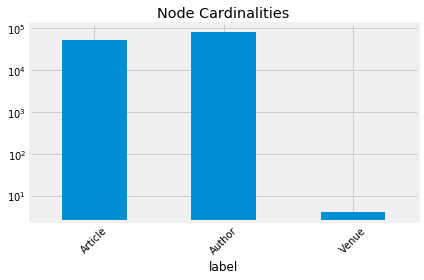

In [13]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
result = {"relType": [], "count": []}
for relationship_type in graph_cit.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph_cit.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


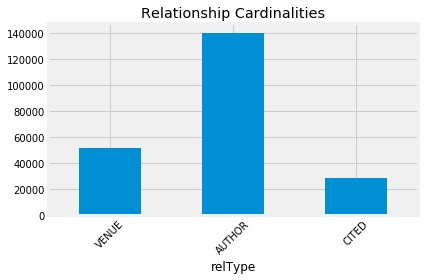

In [15]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, collect(DISTINCT author.name) AS author_list, collect(venue.name) AS venue_list, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY citationsReceived DESC, citationsGiven DESC
LIMIT 25
"""

graph_cit.run(exploratory_query).to_data_frame()

,article,author_list,venue_list,citationsGiven,citationsReceived
0,Rough sets,"[Roman Słowiński, Jerzy W. Grzymala-Busse, Zdz...","[Communications of The ACM, Communications of ...",0,211
1,A method for obtaining digital signatures and ...,"[Adi Shamir, Leonard M. Adleman, Ronald L. Riv...","[Communications of The ACM, Communications of ...",1,125
2,"Pastry: Scalable, Decentralized Object Locatio...","[Antony I. T. Rowstron, Peter Druschel]","[Lecture Notes in Computer Science, Lecture No...",1,108
3,An axiomatic basis for computer programming,[C. A. R. Hoare],[Communications of The ACM],0,93
4,"Time, clocks, and the ordering of events in a ...",[Leslie Lamport],[Communications of The ACM],0,86
5,Symbolic execution and program testing,[James C. King],[Communications of The ACM],0,70
6,N degrees of separation: multi-dimensional sep...,"[Peri L. Tarr, William H. Harrison, M Stanley ...",[international conference on software engineer...,0,68
7,Dynamically discovering likely program invaria...,"[Michael D. Ernst, David Notkin, William G. Gr...",[international conference on software engineer...,9,66
8,Software agents,"[Michael R. Genesereth, Steven P. Ketchpel]","[Communications of The ACM, Communications of ...",0,63
9,Maintaining knowledge about temporal intervals,[James F. Allen],[Communications of The ACM],0,62


In [17]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph_cit.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


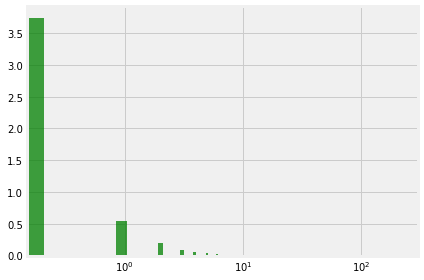

In [18]:
fig1, ax1 = plt.subplots()
# ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1000, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

In [19]:
query = """
MATCH (a:Article)
RETURN size((a)-[:CITED]->()) AS citations
"""

citation_df = graph_cit.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,1.301
min,0.000
25%,0.000
50%,0.000
75%,1.000
90%,2.000
99%,6.000
max,51.000


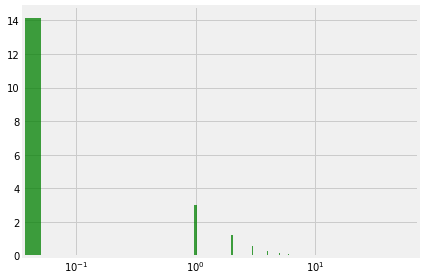

In [20]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1000, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

In [21]:
query = """
MATCH (p:Author)
RETURN size((p)<-[:AUTHOR]-(:Article)) AS n_publications
"""

pub_df = graph_cit.run(query).to_data_frame()
pub_df.describe([.25, .5, .75, .9, .99])

,n_publications
count,80299.000
mean,1.751
std,2.064
min,1.000
25%,1.000
50%,1.000
75%,2.000
90%,3.000
99%,10.000
max,89.000


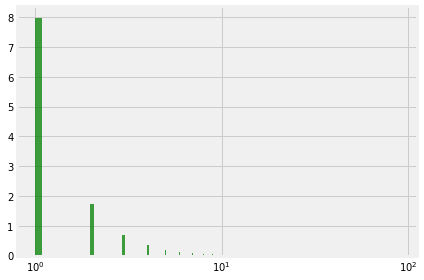

In [22]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(pub_df['n_publications'].dropna()), 1000, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

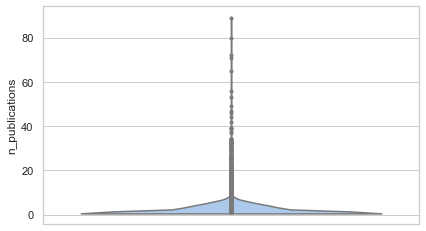

In [23]:
# Plot using seaborn
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(y="n_publications", inner='point', data=pub_df)
# sns.despine(left=True)

# RECOMMENDATIONS

## Exercise 1: Coauthor Collaborative Filtering with Cypher
* Authors may be interested in reading other papers written by their coauthors.
* We can also recommend future collaborators by finding the people that their coauthors have collaborated with.

In [137]:
# Authors who have written the most articles
query = """
MATCH path=(p:Author)<-[:AUTHOR]-(:Article)
RETURN p.name AS name, count(path) AS n_pub
ORDER BY n_pub DESC, name LIMIT 1000
"""

authors_df = graph_cit.run(query).to_data_frame()
authors_df

,name,n_pub
0,Peter G. Neumann,89
1,Peter J. Denning,80
2,Moshe Y. Vardi,72
3,Pamela Samuelson,71
4,Bart Preneel,65
...,...,...
995,James R. Cordy,9
996,Jan Camenisch,9
997,Jan Vanthienen,9
998,Jean Cardinal,9


In [138]:
authors_df[ authors_df['name'].str.startswith('Brian') ]

,name,n_pub
240,Brian Fitzgerald,16
278,Brian Henderson-Sellers,15
741,Brian Warboys,10


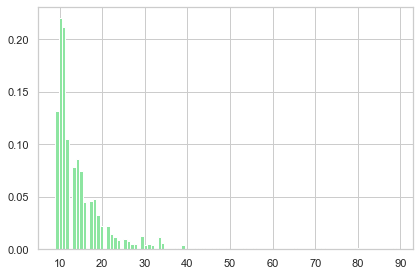

In [139]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(authors_df['n_pub'].dropna()), 100, density=True, facecolor='g', alpha=1.0)
# ax1.set_xscale("log")
plt.tight_layout()
plt.show()

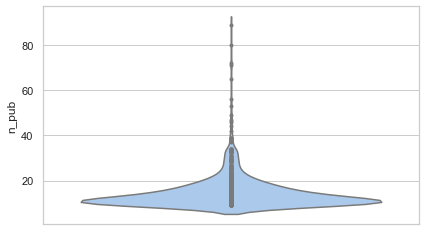

In [140]:
# Plot using seaborn
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(y="n_pub", inner='point', data=authors_df)
# sns.despine(left=True)

In [141]:
# For one author, get the articles published and # of citations received for each article
q_args = {'authorName': authors_df['name'][0] }
q_args

{'authorName': 'Peter G. Neumann'}

In [142]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)
WHERE p.name=$authorName
RETURN  p.name AS name, a.title AS article, a.year as year, size( (a)<-[:CITED]-() ) AS n_cited
ORDER BY name, n_cited DESC, article LIMIT 20
"""

author_pubs_df = graph_cit.run(query, q_args).to_data_frame()
author_pubs_df

,name,article,year,n_cited
0,Peter G. Neumann,Security by obscurity,2003,2
1,Peter G. Neumann,"The foresight saga, redux",2012,2
2,Peter G. Neumann,Are dependable systems feasible,1993,1
3,Peter G. Neumann,"Computers, ethics, and values",1991,1
4,Peter G. Neumann,Crypto policy perspectives,1994,1
5,Peter G. Neumann,Information system security redux,2003,1
6,Peter G. Neumann,Risks of National Identity Cards,2001,1
7,Peter G. Neumann,Risks of automation: a cautionary total-system...,2016,1
8,Peter G. Neumann,Robust open-source software,1999,1
9,Peter G. Neumann,The foresight saga,2006,1


In [143]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)
WHERE p.name=$authorName
RETURN c.name AS collaborator, count(*) as n_collabs
ORDER BY n_collabs DESC, collaborator LIMIT 10
"""

collab_df = graph_cit.run(query, q_args).to_data_frame()
collab_df

,collaborator,n_collabs
0,Lauren Weinstein,3
1,Susan Landau,3
2,Whitfield Diffie,3
3,Matt Blaze,2
4,Rebecca T. Mercuri,2
5,Steven Michael Bellovin,2
6,Alfred Z. Spector,1
7,Anthony G. Lauck,1
8,Bruce Schneier,1
9,Clinton C. Brooks,1


In [144]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)<-[:AUTHOR]-(:Article)-[:AUTHOR]->(cc:Author)
WHERE
    p.name=$authorName
    AND p <> cc
    AND NOT ( (p)<-[:AUTHOR]-()-[:AUTHOR]->(cc) )
RETURN cc.name as `collaborator of collaborator`, count(*) as n_cc_collabs
ORDER BY n_cc_collabs DESC, `collaborator of collaborator` LIMIT 20
"""
#RETURN c.name AS collaborator, collect(DISTINCT cc.name), count(*) as n_cc_collabs

coc_df = graph_cit.run(query, q_args).to_data_frame()
coc_df

,collaborator of collaborator,n_cc_collabs
0,John Ioannidis,10
1,Scott Bradner,9
2,Angelos D. Keromytis,8
3,John Kelsey,7
4,Virgil D. Gligor,5
5,David K. Gifford,4
6,David Wagner,4
7,Gerald Jay Sussman,4
8,Omer Reingold,4
9,Peter Wolcott,4


In [150]:
# For one author, get the articles published and # of citations received for each article
q_args = {'authorName': authors_df['name'][240] }
q_args

{'authorName': 'Brian Fitzgerald'}

In [152]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)
WHERE p.name=$authorName
RETURN  p.name AS name, a.title AS article, a.year as year, size( (a)<-[:CITED]-() ) AS n_cited
ORDER BY name, n_cited DESC, article LIMIT 20
"""

author_pubs_df = graph_cit.run(query, q_args).to_data_frame()
author_pubs_df

,name,article,year,n_cited
0,Brian Fitzgerald,Continuous software engineering and beyond: tr...,2014,3
1,Brian Fitzgerald,Grounded theory in software engineering resear...,2016,2
2,Brian Fitzgerald,Scaling agile methods to regulated environment...,2013,2
3,Brian Fitzgerald,Software development method tailoring at Motorola,2003,2
4,Brian Fitzgerald,"Two's company, three's a crowd: a case study o...",2014,2
5,Brian Fitzgerald,Evidence-based decision making in lean softwar...,2014,1
6,Brian Fitzgerald,Global software development: where are the ben...,2009,1
7,Brian Fitzgerald,2nd international workshop on rapid continuous...,2015,0
8,Brian Fitzgerald,"Collaboration, conflict and control: the 4th w...",2004,0
9,Brian Fitzgerald,Experiences from Representing Software Archite...,2007,0


In [153]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)
WHERE p.name=$authorName
RETURN c.name AS collaborator, count(*) as n_collabs
ORDER BY n_collabs DESC, collaborator LIMIT 10
"""

collab_df = graph_cit.run(query, q_args).to_data_frame()
collab_df

,collaborator,n_collabs
0,Klaas-Jan Stol,6
1,Joseph Feller,5
2,Scott A. Hissam,4
3,Karim R. Lakhani,3
4,Walt Scacchi,2
5,Anders Mattsson,1
6,Andrea Capiluppi,1
7,André van der Hoek,1
8,Björn Lundell,1
9,Brian Lings,1


In [154]:
# For an author, get the articles published and # of citations received for each article
query = f"""
MATCH (p:Author)<-[:AUTHOR]-(a:Article)-[:AUTHOR]->(c:Author)<-[:AUTHOR]-(:Article)-[:AUTHOR]->(cc:Author)
WHERE
    p.name=$authorName
    AND p <> cc
    AND NOT ( (p)<-[:AUTHOR]-()-[:AUTHOR]->(cc) )
RETURN cc.name as `collaborator of collaborator`, count(*) as n_cc_collabs
ORDER BY n_cc_collabs DESC, `collaborator of collaborator` LIMIT 20
"""
#RETURN c.name AS collaborator, collect(DISTINCT cc.name), count(*) as n_cc_collabs

coc_df = graph_cit.run(query, q_args).to_data_frame()
coc_df

,collaborator of collaborator,n_cc_collabs
0,Holger Giese,5
1,Chris Jensen,4
2,Gabriel A. Moreno,4
3,Grace A. Lewis,4
4,Judith A. Stafford,4
5,Kurt C. Wallnau,4
6,Robert C. Seacord,4
7,Gerald Bortis,3
8,Ivar Jacobson,3
9,Klaus Pohl,3


In [158]:
sum(coc_df['n_cc_collabs'] > 3)

7

## Exercise 2: Article Recommendations with Personalized PageRank
* PageRank is an algorithm that measures the transitive influence or connectivity of nodes. It can be computed by either iteratively distributing one node’s rank (originally based on degree) over its neighbors or by randomly traversing the graph and counting the frequency of hitting each node during these walks.
* Personalized PageRank (PPR) is a variant of this algorithm that is biased towards a set of source nodes. It is often used as part of building recommender systems.